In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from math import isinf
from sklearn import ensemble 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils import compute_class_weight

In [44]:
data = pd.read_csv('train.csv')

# Pre-Processes

## Cleaner

- ### Type

Is directly encoded

- ### Neighborhood

Zone


In [45]:
data['zone'] = data['neighborhood'].str.slice(stop=8)
data['zone'] = data['zone'].str.replace('منطقه', '')
data['zone'] = data['zone'].astype(float)

Neighborhood & Street


In [46]:
data['neighborhood'] = data['neighborhood'].str[13:len(data['neighborhood'])-13]
data['neighborhood'] = data['neighborhood'].str.split(' خیابان ')

In [47]:
data = data.drop(data[data['neighborhood'].isna()].index)

In [48]:
data['street'] = data['neighborhood'].apply(lambda x:x.pop(1))
data['neighborhood'] = data['neighborhood'].apply(lambda x:x.pop())

- ### Description


In [49]:
data['elevator'] = data['description'].str.contains('آسانسور دارد')

data['parking'] = data['description'].str.contains('پارکینگ دارد')

data['storage'] = data['description'].str.contains('انباری دارد')

data['yard'] = data['description'].str.contains('حیاط')

data['balcony'] = data['description'].str.contains('بالکن|بالکنی')

data['reconstructed'] = data['description'].str.contains('بازسازی')

data = data.drop('description', axis=1)


- ### Floor


In [50]:
data['floor'].replace('همکف', 0, inplace=True)

data['floor'] = data['floor'].astype(int)

In [51]:
data['floor'].replace(-130, float('nan'), inplace=True)

In [52]:
data = data.drop(data[data['floor'].isna()].index)

- ### Bedrooms


In [53]:
data['bedrooms'].replace(0, float('nan'), inplace=True)

In [54]:
data = data.drop(data[data['bedrooms'].isna()].index)

- ### Price


In [55]:
data['price'] = data['price'].str.replace(' تومان','')
data['price'] = data['price'].str.replace(',', '')
data['price'] = data['price'].str.replace('توافقی', '0')

data['price'] = data['price'].astype('int64') # int and int32 are too short

In [56]:
data = data.drop(data[data['price'] == 0].index)
data = data.drop(data[data['price'] == 1111111].index)
data = data.drop(data[data['price'] == 11111111].index)

- ### Age

In [57]:
data['age'] = data['age'].str.replace('تازه ساز', '0')
data['age'] = data['age'].str.replace(' سال ساخت', '')

# Best way to ignore NaN values is to convert to Float
data['age'] = data['age'].astype(float)

# Hand correcting that single one (and also to make automated correction easier)
data['age'] = data['age'].replace(98.0, 4.0)

# Correcting the 13xx/14xx dates with their age rather than year built
data.loc[data['age'] > 1300, 'age'] = 1402 - data['age']

- ### Area

In [58]:
data = data.drop(data[data['area'] >= 1000].index)

- ### Lat & long

In [59]:
data = data.drop(['latitude', 'longitude'], axis=1)

## NaNs

In [60]:
data['age'] = data['age'].replace(np.nan, 0)

data ['floor'] = data['floor'].replace(np.nan, 0)

data['bedrooms'] = data['bedrooms'].replace(np.nan, 1)

cols = ['elevator', 'parking', 'storage', 'yard', 'balcony', 'reconstructed']
data[cols] = data[cols].replace(float('nan'), False)


In [61]:
data.isna().sum()

type             0
area             0
neighborhood     0
age              0
floor            0
bedrooms         0
price            0
zone             0
street           0
elevator         0
parking          0
storage          0
yard             0
balcony          0
reconstructed    0
dtype: int64

## Further Pre-Processing

In [62]:
data = data.drop(data[data['area'] > 450].index)

data = data.drop(data[data['area'] == 0].index)

In [63]:
data = data.drop(data[(data['floor'] > 10) | (data['floor'] < 0)].index)

In [64]:
data = data.drop(data[data['bedrooms'] > 5].index)

In [65]:
data = data.drop(data[data['price'] > 40000000000].index)

## Encoding

In [66]:
def label_encode(df, columns):
    le = LabelEncoder()
    data = df.copy()
    for col in columns:
        data[col] = le.fit_transform(df[col])
    return data

In [67]:
columns = ['type', 'neighborhood', 'street', 'elevator', 'parking', 
           'storage', 'yard', 'balcony', 'reconstructed']

In [68]:
label_encoded = label_encode(data, columns)

label_encoded.to_csv('label_final_data2.csv', index=False)

In [69]:
data = pd.read_csv('label_final_data2.csv')

### Eliminating Infs

In [70]:
data = data.replace([np.inf, -np.inf], np.finfo('float64').max)

In [71]:
data.isin([np.inf, -np.inf]).sum().sum()

0

### Splitting

In [72]:
x = data.drop('price', axis=1)
y = data['price']
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

In [73]:
x = x.replace([np.inf, -np.inf], np.finfo('float64').max)
y = y.replace([np.inf, -np.inf], np.finfo('float64').max)

In [74]:
values_list = y.value_counts()
lesser_values = values_list.loc[values_list == 1].index

In [75]:
# Doing the removal for x so both x and y lengths are equal
for num in lesser_values:
    x.drop(y[y == num].index, inplace=True, axis=0)  
    
for num in lesser_values:
    y.drop(y[y == num].index, inplace=True, axis=0)  

In [76]:
train_index, test_index = next(sss.split(x, y))

In [77]:
X_train = data.iloc[test_index].drop('price', axis=1)
Y_train = data.iloc[test_index].price
X_test = data.iloc[test_index].drop('price', axis=1)
Y_test = data.iloc[test_index].price

### Scaling

In [78]:
cols = X_train.columns
scaler = MinMaxScaler()

In [79]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
X_test  = pd.DataFrame(X_test, columns=[cols])
X_train = pd.DataFrame(X_train, columns=[cols])

### Correlations

(-1.0, 14.0)

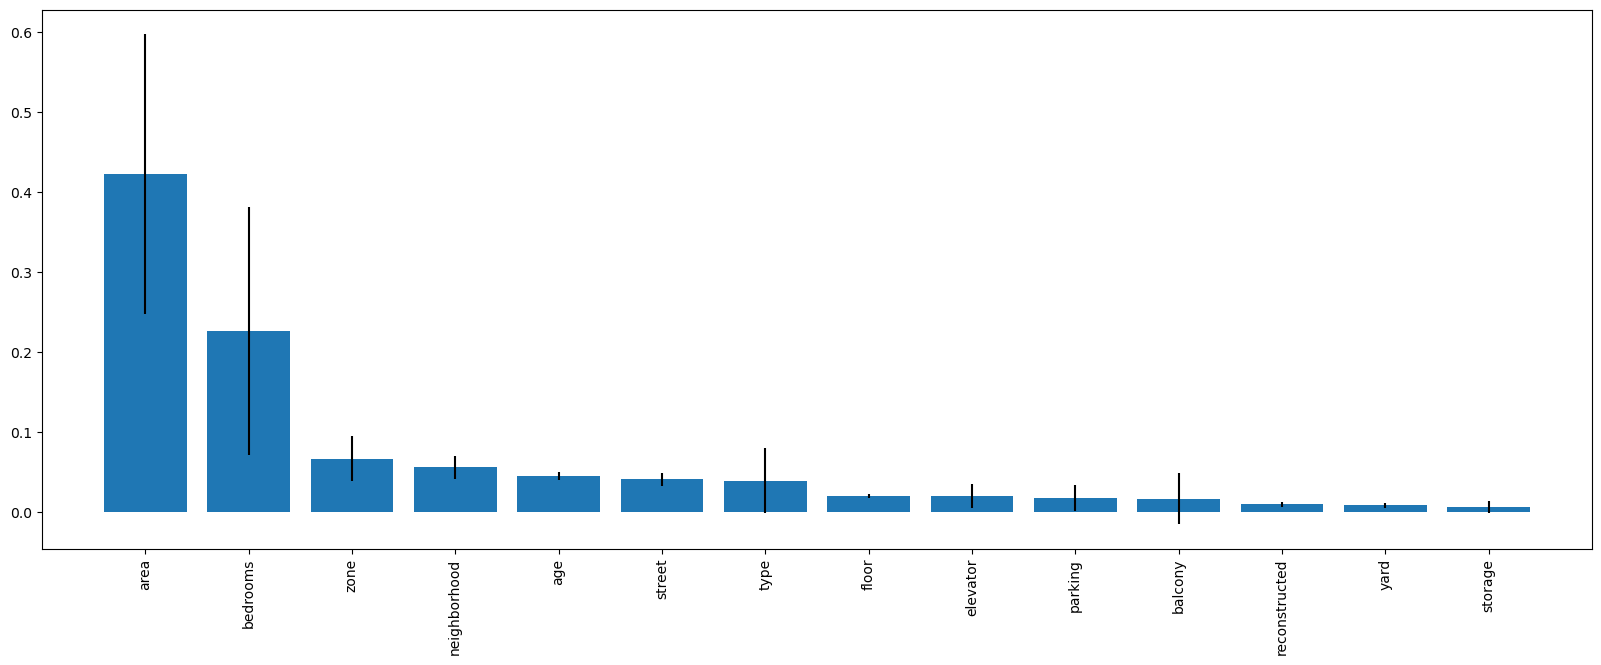

In [81]:
feature_name = x.columns.values
model = ensemble.ExtraTreesRegressor(n_estimators=30, max_depth=30, max_features=.5, n_jobs=-1, random_state=0)
model.fit(X_train, Y_train.to_numpy())
importance = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importance)[::-1][:20]
plt.figure(figsize=(20, 7))
plt.bar(range(len(indices)), importance[indices], yerr=std[indices], align='center')
plt.xticks(range(len(indices)), feature_name[indices], rotation='vertical')
plt.xlim([-1, len(indices)])

### Feature Selection

In [82]:
chi2_features = SelectKBest(chi2, k=10)

dfscaled = X_train.copy()

X_kbest_features = chi2_features.fit_transform(dfscaled, Y_train)
chidata = pd.DataFrame(X_kbest_features)

chifeatures50 = []

for i in chidata.columns:
    for j in dfscaled.columns:
        if (chidata[i] == dfscaled[j]).sum() == len(chidata):
            print(j)
            chifeatures50.append(j)

('type',)
('area',)
('neighborhood',)
('bedrooms',)
('zone',)
('elevator',)
('parking',)
('yard',)
('balcony',)
('reconstructed',)


In [83]:
indices = np.argsort(importance)[::-1][:10]
fimport = list(feature_name[indices])
fimport

['area',
 'bedrooms',
 'zone',
 'neighborhood',
 'age',
 'street',
 'type',
 'floor',
 'elevator',
 'parking']

In [84]:
X_test.to_csv('X_test(1).csv', index=False)
Y_test.to_csv('Y_test(1).csv', index=False)

X_train.to_csv('X_train(1).csv', index=False)
Y_train.to_csv('Y_train(1).csv', index=False)